In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from scipy.special import gammaln
from paglm.core import *
from scipy.linalg import hankel

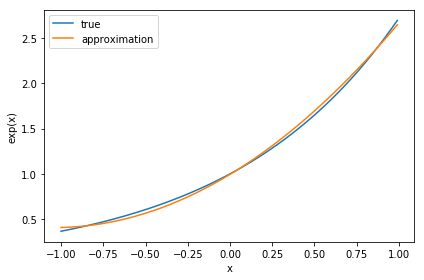

In [3]:
# example polynomial approximation
xlim = np.array([-1.0,1.0]) 
a,b,c = compute_chebyshev(np.exp,xlim,power=2,dx=0.01)

xx = np.arange(xlim[0],xlim[1],0.01)
plt.figure()
plt.plot(xx,np.exp(xx))
plt.plot(xx,a + b*xx + c*(xx**2))
plt.legend(["true","approximation"])
plt.xlabel("x")
plt.ylabel("exp(x)")
plt.tight_layout()

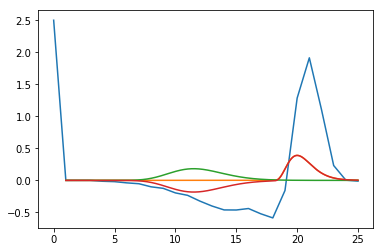

In [54]:
from scipy.stats import gamma

x = np.arange(1,25,0.01)
w2 = gamma.pdf(x, a=5, loc=18, scale=0.5)
w3 = gamma.pdf(x, a=20, loc=2, scale=0.5)

plt.figure()
plt.plot(w)
plt.plot(x,w2)
plt.plot(x,w3)
plt.plot(x,w2-w3)

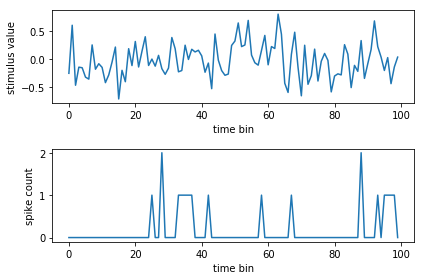

In [5]:
# simulate Poisson GLM with autoregressive stimulus filter
w = np.array([ 2.5, 0.0, 0.0, 0.0, -0.01368046, -0.01986828,
 -0.03867417, -0.05218188, -0.10044614, -0.12434759, -0.19540891, -0.23327453,
 -0.32255702, -0.40001292, -0.46124429, -0.46235415, -0.43928836, -0.52066692,
 -0.58597496, -0.15804368,  1.2849799,   1.91338741,  1.10402054,  0.23188751,
  0.00331092, -0.0111924, ])
## here -> put Jonathan's code for generating a temporal stimulus filter 

D = np.shape(w)[0] # dimensionality of weights
T = 20000 # time bins

# binary stimulus
x = np.random.randint(0,2,[T,])-0.5

# Gaussian stimulus
x = 0.3*np.random.randn(T)

# spiking bin size
dtSp = 0.01 

# generate design matrix 
X = hankel(np.append(np.zeros(D-2),x[:T-D+2]),x[T-D+1:])
X = np.concatenate((np.ones([T,1]),X),axis=1)

# generate spikes 
y = np.random.poisson(np.exp(X@w)*dtSp)

# look at data
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[:100])
plt.xlabel("time bin")
plt.ylabel("stimulus value")
plt.subplot(2,1,2)
plt.plot(y[:100])
plt.xlabel("time bin")
plt.ylabel("spike count")
plt.tight_layout()

In [4]:
# prior
lambda_ridge = np.power(2.0,4)
lambda_ridge = 0.0
Cinv = lambda_ridge*np.eye(D)
Cinv[0,0] = 0.0 # no prior on bias

In [5]:
## fit with paGLM 

# interval 
intervals = [np.array([0.5,4.5])]

# build sufficient statistics
suff, X_sub, y_sub = process_data(X,y,subset_frac=0.1)

# fit model
w_paglm, interval = fit_paglm(np.exp,suff,dtSp,intervals,Cinv=Cinv,X_sub=X_sub,y_sub=y_sub)

In [6]:
# fit with MAP
from scipy.optimize import minimize
res = minimize(lambda w: -poisson_log_like(w,y,X,dtSp,np.exp,Cinv), np.zeros([D,]),method='L-BFGS-B', tol=1e-4,options={'disp': True})
w_map = res.x

In [7]:
# fit will ELL
Cov = (0.3**2)*np.eye(D-1)
X_demeaned = X - np.mean(X,0,keepdims=True)
w_ell = np.zeros(D)
w_ell[1:] = np.linalg.lstsq(np.sum(y)*Cov,X_demeaned[:,1:].T@y,rcond=True)[0]
w_ell[0] = np.log(np.sum(y)/np.size(y)/dtSp * np.exp( - w_ell[1:].T@Cov@w_ell[1:]/2.0))

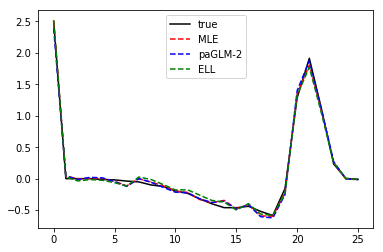

In [8]:
# compare solutions
plt.figure()
plt.plot(w,'k')
plt.plot(w_map,'r--')
plt.plot(w_paglm,'b--')
plt.plot(w_ell,'g--')
plt.legend(['true','MLE','paGLM-2','ELL'])
# plt.savefig('comparison_with_ell.png')

Text(0,0.5,'probability')

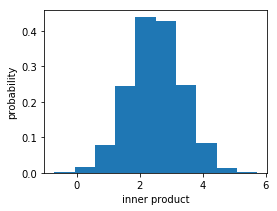

In [9]:
# examine distribution of inner products
plt.figure(figsize=[4,3])
plt.hist(X@w_map,density=True)
plt.xlabel("inner product")
plt.ylabel("probability")